<a href="https://colab.research.google.com/github/Swarna1804/Data_privacy_security/blob/main/Adverserial_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load the dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# Get sample image and label
sample_image, sample_label = next(iter(testloader))


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.28MB/s]


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1  # Keep it 1 for quick training
for epoch in range(num_epochs):
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training complete!")

Epoch [1/1], Loss: 0.0829
Training complete!


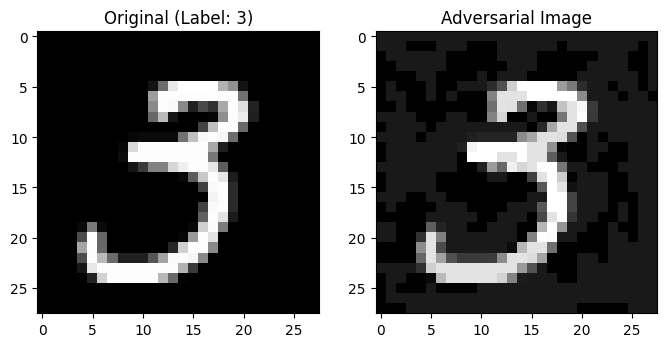

In [ ]:
def fgsm_attack(image, epsilon, gradient):
    sign_data_grad = gradient.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # Keep in valid range
    return perturbed_image

# Select an image from test set
image, label = next(iter(testloader))
image, label = image.to(device), label.to(device)

# Make prediction
image.requires_grad = True
output = model(image)
init_pred = output.max(1, keepdim=True)[1]

# Compute loss
loss = criterion(output, label)
model.zero_grad()
loss.backward()

# Get adversarial example
perturbed_image = fgsm_attack(image, epsilon=0.1, gradient=image.grad)

# Plot original and adversarial image
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image.cpu().detach().squeeze(), cmap="gray")
plt.title(f"Original (Label: {label.item()})")

# Adversarial Image
plt.subplot(1, 2, 2)
plt.imshow(perturbed_image.cpu().detach().squeeze(), cmap="gray")
plt.title("Adversarial Image")

plt.show()

In [ ]:
adv_examples = []
for img, label in trainloader:
    img, label = img.to(device), label.to(device)

    # Enable gradient tracking
    img.requires_grad = True

    # Forward pass
    output = model(img)

    # Compute loss
    loss = criterion(output, label)
    model.zero_grad()

    # Backward pass to compute gradients
    loss.backward()

    # Generate adversarial example
    adv_img = fgsm_attack(img, epsilon=0.1, gradient=img.grad)
    adv_examples.append(adv_img)

In [ ]:

# Train again on normal + adversarial data
for epoch in range(1):
    for (images, labels), adv_image in zip(trainloader, adv_examples):
        images, labels = images.to(device), labels.to(device)

        # Train with both normal and adversarial examples
        images = torch.cat((images, adv_image))
        labels = torch.cat((labels, labels))

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("Adversarial Training Done!")

Adversarial Training Done!


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

train-00000-of-00007.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00001-of-00007.parquet:   0%|          | 0.00/385M [00:00<?, ?B/s]

train-00002-of-00007.parquet:   0%|          | 0.00/68.9M [00:00<?, ?B/s]

train-00003-of-00007.parquet:   0%|          | 0.00/74.1M [00:00<?, ?B/s]

train-00004-of-00007.parquet:   0%|          | 0.00/59.9M [00:00<?, ?B/s]

train-00005-of-00007.parquet:   0%|          | 0.00/57.6M [00:00<?, ?B/s]

train-00006-of-00007.parquet:   0%|          | 0.00/57.8M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/78.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5216 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/624 [00:00<?, ? examples/s]

Epoch 1 completed


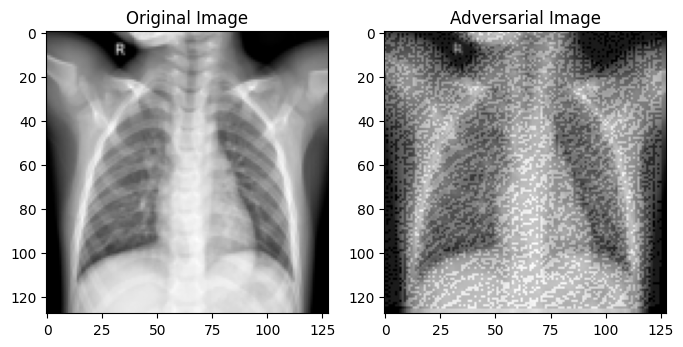

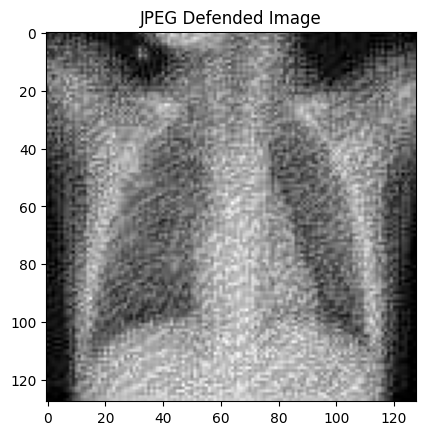

In [ ]:
# STEP 1: Install dependencies
!pip install datasets torchvision matplotlib --quiet

# STEP 2: Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# STEP 3: Load dataset
dataset = load_dataset("hf-vision/chest-xray-pneumonia", split="train")

# STEP 4: Preprocess data (binary classification: pneumonia vs normal)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(),  # convert to 1 channel
    transforms.ToTensor()
])

class ChestXRayDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        label = 0 if self.dataset[idx]["label"] == "NORMAL" else 1
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

torch.manual_seed(0)
data = ChestXRayDataset(dataset, transform=transform)
loader = DataLoader(data, batch_size=32, shuffle=True)

# STEP 5: Define simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(16*30*30, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # [B, 8, 126, 126]
        x = F.max_pool2d(x, 2)     # [B, 8, 63, 63]
        x = F.relu(self.conv2(x))  # [B, 16, 61, 61]
        x = F.max_pool2d(x, 2)     # [B, 16, 30, 30]
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# STEP 6: Train the model (1 epoch for demo)
model.train()
for epoch in range(1):
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} completed")

# STEP 7: FGSM Attack Function
def fgsm_attack(image, epsilon, gradient):
    sign = gradient.sign()
    adv = image + epsilon * sign
    return torch.clamp(adv, 0, 1)

# STEP 8: Pick a single image and generate adversarial example
model.eval()
sample_img, sample_label = next(iter(loader))
img, label = sample_img[0:1].cuda(), sample_label[0:1].cuda()
img.requires_grad = True

output = model(img)
loss = criterion(output, label)
model.zero_grad()
loss.backward()

# Apply FGSM
epsilon = 0.1
adv_img = fgsm_attack(img, epsilon, img.grad)

# STEP 9: Visualize original vs adversarial
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img.squeeze().detach().cpu(), cmap='gray')
axs[0].set_title("Original Image")
axs[1].imshow(adv_img.squeeze().detach().cpu(), cmap='gray')
axs[1].set_title("Adversarial Image")
plt.show()

# STEP 10 (Optional): JPEG Defense
def jpeg_defense(tensor_img):
    pil_img = to_pil_image(tensor_img.squeeze().detach().cpu())
    pil_img.save("compressed.jpg", "JPEG", quality=50)
    return transform(Image.open("compressed.jpg")).unsqueeze(0).cuda()

jpeg_img = jpeg_defense(adv_img)

# Visualize defended image
plt.imshow(jpeg_img.squeeze().detach().cpu(), cmap="gray")
plt.title("JPEG Defended Image")
plt.show()


Epoch 1 completed
Clean Accuracy: 100.00%
FGSM Accuracy: 100.00%
PGD Accuracy: 100.00%


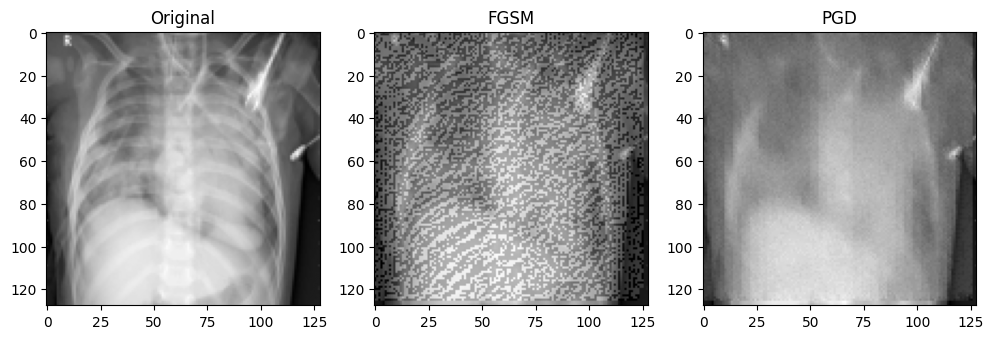

In [ ]:
# STEP 1: Install dependencies
!pip install datasets torchvision matplotlib --quiet

# STEP 2: Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# STEP 3: Load dataset
dataset = load_dataset("hf-vision/chest-xray-pneumonia", split="train")

# STEP 4: Preprocess data
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

class ChestXRayDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        label = 0 if self.dataset[idx]["label"] == "NORMAL" else 1
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

torch.manual_seed(0)
data = ChestXRayDataset(dataset, transform=transform)
loader = DataLoader(data, batch_size=32, shuffle=True)

# STEP 5: Define CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(16*30*30, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = SimpleCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# STEP 6: Train
model.train()
for epoch in range(1):
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} completed")

# STEP 7: FGSM
def fgsm_attack(image, epsilon, gradient):
    return torch.clamp(image + epsilon * gradient.sign(), 0, 1)

# STEP 8: PGD
def pgd_attack(model, image, label, epsilon=0.1, alpha=0.01, num_steps=40):
    ori_image = image.clone().detach()
    adv_image = image.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        output = model(adv_image)
        loss = criterion(output, label)
        model.zero_grad()
        loss.backward()
        adv_image = adv_image + alpha * adv_image.grad.sign()
        eta = torch.clamp(adv_image - ori_image, min=-epsilon, max=epsilon)
        adv_image = torch.clamp(ori_image + eta, 0, 1).detach_().requires_grad_(True)

    return adv_image

# STEP 9: Evaluate Function
def evaluate_accuracy(model, loader, attack=None, attack_name="Clean", epsilon=0.1):
    model.eval()
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        if attack == fgsm_attack:
            images.requires_grad = True
            outputs = model(images)
            loss = criterion(outputs, labels)
            model.zero_grad()
            loss.backward()
            images = fgsm_attack(images, epsilon, images.grad)
        elif attack == pgd_attack:
            new_images = []
            for i in range(images.size(0)):
                img = images[i:i+1]
                lbl = labels[i:i+1]
                adv_img = pgd_attack(model, img, lbl, epsilon=epsilon)
                new_images.append(adv_img)
            images = torch.cat(new_images, dim=0)

        with torch.no_grad():
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100. * correct / total
    print(f"{attack_name} Accuracy: {accuracy:.2f}%")
    return accuracy

# STEP 10: Accuracy Results
clean_acc = evaluate_accuracy(model, loader, attack=None, attack_name="Clean")
fgsm_acc = evaluate_accuracy(model, loader, attack=fgsm_attack, attack_name="FGSM", epsilon=0.1)
pgd_acc = evaluate_accuracy(model, loader, attack=pgd_attack, attack_name="PGD", epsilon=0.1)

# STEP 11: Visualize Original vs FGSM vs PGD
model.eval()
sample_img, sample_label = next(iter(loader))
img, label = sample_img[0:1].cuda(), sample_label[0:1].cuda()

# FGSM image
img.requires_grad = True
output = model(img)
loss = criterion(output, label)
model.zero_grad()
loss.backward()
fgsm_img = fgsm_attack(img, 0.1, img.grad)

# PGD image
pgd_img = pgd_attack(model, img.detach(), label)

# Display
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img.squeeze().detach().cpu(), cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(fgsm_img.squeeze().detach().cpu(), cmap='gray')
axs[1].set_title("FGSM")
axs[2].imshow(pgd_img.squeeze().detach().cpu(), cmap='gray')
axs[2].set_title("PGD")
plt.show()


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Clean Accuracy: 100.00%
FGSM Accuracy: 100.00%
PGD Accuracy: 100.00%


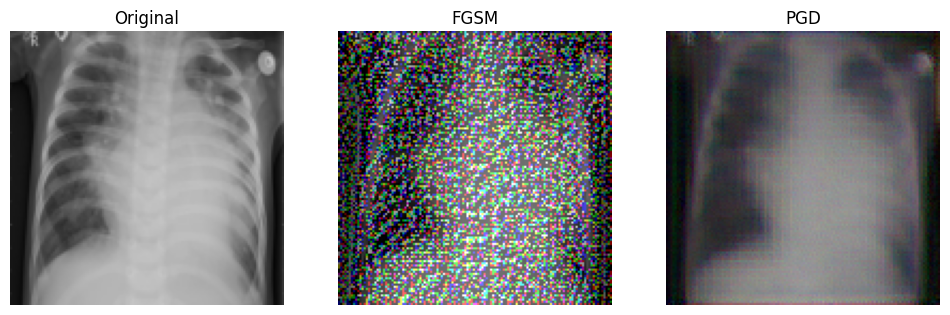

In [ ]:
!pip install -q datasets torchvision matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

# Load dataset
train_split = load_dataset("hf-vision/chest-xray-pneumonia", split="train[:80%]")
test_split = load_dataset("hf-vision/chest-xray-pneumonia", split="train[80%:]")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda image: image.convert("RGB")),  # Convert to RGB
    transforms.ToTensor()
])

# Custom Dataset
class ChestXRayDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = 0 if self.dataset[idx]['label'] == 'NORMAL' else 1
        if self.transform:
            image = self.transform(image)
        return image, label

# Loaders
train_data = ChestXRayDataset(train_split, transform)
test_data = ChestXRayDataset(test_split, transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# CNN model
# CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # Change input channels to 3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128) # Adjust this based on the actual output after conv layers
        # You might need to calculate the correct input size.
        # Refer to the explanation of the calculations below the code.
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32) # Adjust this based on the actual output after conv layers
        # You might need to calculate the correct input size.
        # Refer to the explanation of the calculations below the code.
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train model
model = CNNModel().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train for 5 epochs
for epoch in range(5):
    model.train()
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} completed")

# Adversarial Attacks
def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    perturbed = images + epsilon * images.grad.sign()
    return torch.clamp(perturbed, 0, 1)

def pgd_attack(model, images, labels, epsilon, alpha, num_steps):
    original = images.clone().detach()
    perturbed = images.clone().detach()
    for _ in range(num_steps):
        perturbed.requires_grad = True
        outputs = model(perturbed)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = perturbed.grad.data
        perturbed = perturbed + alpha * grad.sign()
        perturbed = torch.max(torch.min(perturbed, original + epsilon), original - epsilon)
        perturbed = torch.clamp(perturbed, 0, 1).detach()
    return perturbed

# Evaluation
def evaluate_accuracy(model, loader, attack=None, attack_name="", epsilon=0.1, alpha=0.01, num_steps=40):
    model.eval()
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        if attack == fgsm_attack:
            images = fgsm_attack(model, images, labels, epsilon)
        elif attack == pgd_attack:
            images = pgd_attack(model, images, labels, epsilon, alpha, num_steps)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"{attack_name} Accuracy: {acc:.2f}%")
    return acc

# Evaluate
clean_acc = evaluate_accuracy(model, test_loader, attack=None, attack_name="Clean")
fgsm_acc = evaluate_accuracy(model, test_loader, attack=fgsm_attack, attack_name="FGSM", epsilon=0.3)
pgd_acc = evaluate_accuracy(model, test_loader, attack=pgd_attack, attack_name="PGD", epsilon=0.3, alpha=0.01, num_steps=40)

# Visualize one sample
model.eval()
sample_image, sample_label = next(iter(test_loader))
sample_image, sample_label = sample_image[0:1].cuda(), sample_label[0:1].cuda()

# Adversarial examples
fgsm_img = fgsm_attack(model, sample_image.clone(), sample_label, epsilon=0.3).detach().cpu().squeeze()
pgd_img = pgd_attack(model, sample_image.clone(), sample_label, epsilon=0.3, alpha=0.01, num_steps=40).detach().cpu().squeeze()
original = sample_image.squeeze().cpu()

# Plot
# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original.permute(1, 2, 0), cmap='gray') # Permute the dimensions
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(fgsm_img.permute(1, 2, 0), cmap='gray') # Permute the dimensions
plt.title("FGSM")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pgd_img.permute(1, 2, 0), cmap='gray') # Permute the dimensions
plt.title("PGD")
plt.axis('off')
plt.show()
